# Saturating MinMaxGANs Implementation
                                                        - K.Krishna Dhakshin

##Import Essential Stuff

In [0]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Loading DataSets (CIFAR10/MNIST)

In [0]:
bool = False  #set to true for CIFAR10 and false for MNIST

In [0]:
if bool:
  trainset = dset.CIFAR10(root='./cifar10', train=True, transform=transforms.Compose([transforms.Resize((32, 32)),  transforms.ToTensor(), transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))]), download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
  nc = 3
else:
  trainset = dset.MNIST(root='./mnist', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std = (0.5,))]), download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
  nc = 1

##Visualizing DataSet

In [0]:
len(trainset)

60000

In [0]:
len(trainloader)

600

In [0]:
batch = next(iter(trainloader))
vutils.make_grid(batch[0]).size()

torch.Size([3, 444, 274])

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

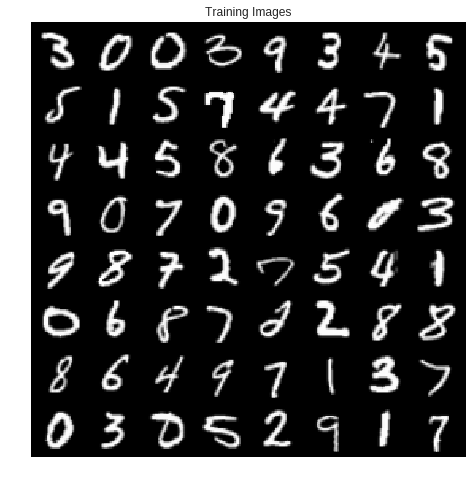

In [0]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

100

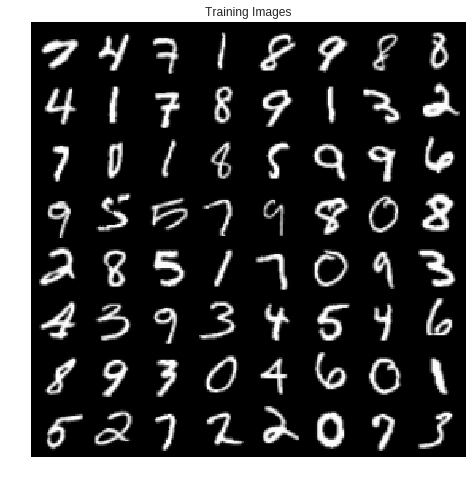

In [0]:
batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
batch[0].size(0)

## Designing the GANs Model

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [0]:
netG = Generator()
netG.cuda()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [0]:
netD = Discriminator()
netD.cuda()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.3)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Dropout2d(p=0.3)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): Dropout2d(p=0.3)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
netG.apply(weights_init)
print(netG)
netD.apply(weights_init)
print(netD)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=

In [0]:
real = 1
fake = 0

In [0]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.002)
optimizerG = optim.Adam(netG.parameters(), lr=0.002)

In [0]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [0]:
device

device(type='cuda', index=0)

##Training Network

In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

In [0]:
for epoch in range(100):
  for i, data in enumerate(trainloader, 0):
        netD.zero_grad()
        data[0] = data[0].cuda()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real, device=device)
        output = netD(torch.cuda.FloatTensor(real_cpu)).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fakeim = netG(noise)
        label.fill_(fake)
        output = netD(fakeim.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fakeim = netG(noise)
        label.fill_(real)
        output = netD(torch.cuda.FloatTensor(fakeim)).view(-1)
        errG = -1/(torch.log(1-output)).sum().mean()
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print('[%d/10][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or ((i == len(trainloader)-1)):
            with torch.no_grad():
                fakeim = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakeim, padding=2, normalize=True))
        iters += 1

[0/10][0/600]	Loss_D: 0.0005	Loss_G: 30.0751	D(x): 0.9996	D(G(z)): 0.0001 / 0.0003
[0/10][1/600]	Loss_D: 0.0055	Loss_G: 11.0586	D(x): 0.9957	D(G(z)): 0.0001 / 0.0009
[0/10][2/600]	Loss_D: 0.0002	Loss_G: 105.1204	D(x): 0.9998	D(G(z)): 0.0000 / 0.0001
[0/10][3/600]	Loss_D: 0.0004	Loss_G: 142.0232	D(x): 0.9999	D(G(z)): 0.0003 / 0.0001
[0/10][4/600]	Loss_D: 0.0002	Loss_G: 120.9968	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/10][5/600]	Loss_D: 0.0007	Loss_G: 51.3266	D(x): 0.9997	D(G(z)): 0.0004 / 0.0002
[0/10][6/600]	Loss_D: 0.0008	Loss_G: 48.5134	D(x): 0.9995	D(G(z)): 0.0003 / 0.0002
[0/10][7/600]	Loss_D: 0.0032	Loss_G: 60.1357	D(x): 0.9972	D(G(z)): 0.0000 / 0.0002
[0/10][8/600]	Loss_D: 0.0019	Loss_G: 138.0453	D(x): 0.9987	D(G(z)): 0.0005 / 0.0001
[0/10][9/600]	Loss_D: 0.0016	Loss_G: 167.3469	D(x): 0.9999	D(G(z)): 0.0014 / 0.0001
[0/10][10/600]	Loss_D: 0.0007	Loss_G: 47.3040	D(x): 0.9996	D(G(z)): 0.0003 / 0.0002
[0/10][11/600]	Loss_D: 0.0045	Loss_G: 403.4057	D(x): 0.9959	D(G(z)): 0.0001 / 0.0

RuntimeError: ignored

## Visualising Generated Samples and Error functions

RuntimeError: ignored

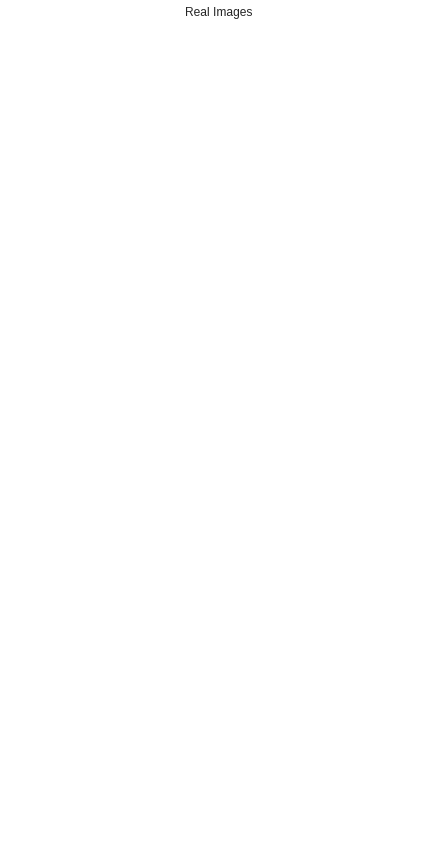

In [0]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

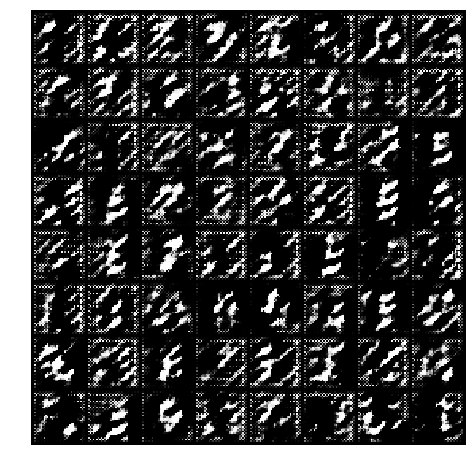

In [0]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

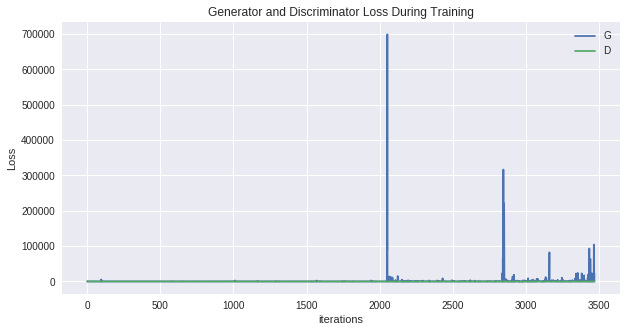

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saving Model and Data in files and Uploading to Drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                 
drive = GoogleDrive(gauth)

In [0]:
def upld_drive(x):  
  model_file = drive.CreateFile({'title' : x})             
  model_file.SetContentFile(x)  
  model_file.Upload()
  drive.CreateFile({'id': model_file.get('id')})

In [0]:
if bool!=True:
  torch.save(netG, 'GenMNIST')
  torch.save(netD, 'DisMNIST')
  torch.save(img_list, 'ImgMNIST')
  torch.save(G_losses, 'GlossMNIST')
  torch.save(D_losses, 'DlossMNIST')
  upld_drive('GenMNIST')
  upld_drive('DisMNIST')
  upld_drive('ImgMNIST')
  upld_drive('GlossMNIST')
  upld_drive('DlossMNIST')

In [0]:
if bool:
  torch.save(netG, 'GenCIFAR10')
  torch.save(netD, 'DisCIFAR10')
  torch.save(img_list, 'ImgCIFAR10')
  torch.save(G_losses, 'GlossCIFAR10')
  torch.save(D_losses, 'DlossCIFAR10')
  upld_drive('GenCIFAR10')
  upld_drive('DisCIFAR10')
  upld_drive('ImgCIFAR10')
  upld_drive('GlossCIFAR10')
  upld_drive('DlossCIFAR10')

In [0]:
netG=torch.load('GenMNIST')
netD=torch.load('DisMNIST')
img_list=torch.load('ImgMNIST')
G_losses=torch.load('GlossMNIST')
D_losses=torch.load('DlossMNIST')

In [0]:
netG=torch.load('GenCIFAR10')
netD=torch.load('DisCIFAR10')
img_list=torch.load('ImgCIFAR10')
G_losses=torch.load('GlossCIFAR10')
D_losses=torch.load('DlossCIFAR10')

# Reason for not being as Good as Unsaturating Heuristic
          In the minimax game, the discriminator minimizes a cross entropy loss, but the generator maximizes the same cross entropy. Unfortunately for the generator, when the discriminator successfully rejects generator samples with high confidence, i.e, D(G(z)) is very close to zero, the generator’s gradient is approximately zero.
          Thus the generator will hardly do any gradient update at the time when the discriminator wins by a good margin, since the derivatives are close to zero. The main problem is that this represents the most common case when starting the game. The generatoralmost always starts the game losing to the discriminator. So, it is never updated properly and gets steamrolled on by the discriminator.
          Changing -log(1−D(G(z))) to log(D(G(z))) may not seem like a big deal because they both look nearly same with very little qualitative difference. But the thing is the gradient of the latter function is significantly larger when the discriminator is winning that it manages to give a good enough gradient to the generator to improve upon.
>![Graph](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRXW_CH6ft2zAupM7B-3P3OLA8l3NSJXCnN3uevxyyNdOi-Qv_b)
          This graph from NIPS 2016 Goodfellow's lecture demonstrates the above phenomenon very well. The graph of log(D(G(z))) has a better slope than -log(1−D(G(z))) when D(G(z)) is small.